# Разбор ДЗ 4-5

Урок 4:
1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.
2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)
6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.ряда.

Урок 5:
1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. сделайте ее перрасчет (ресемплинг) в представление по неделям.
4. Постройте модель предсказания 1-й точки от текущей (h=1, p, q и d - необходимо выбрать с учетом задачи).
5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

%matplotlib inline
import warnings 

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


## Преобразование Бокса-Кокса

In [2]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
import numpy as np
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [3]:
t=range(1000)
d_t =1020+ np.array(t) + np.sin(np.array(t)/3.14)*np.array(t)*0.3+20*np.random.random(1000)


In [4]:
d_bc, lmbda = scs.boxcox(d_t[1:]) # прибавляем единицу, так как в исходном ряде есть нули
lmbda

-0.08309206010402057

In [5]:
d_bc1, lmbda1 = scs.boxcox(d_bc) # прибавляем единицу, так как в исходном ряде есть нули
lmbda1

0.6963721383669313

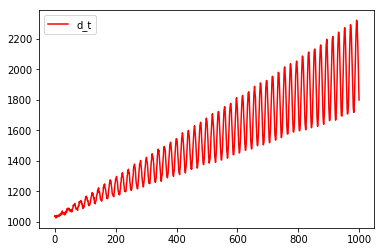

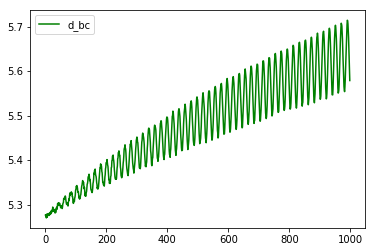

In [6]:
plt.plot(d_t,'r',label='d_t')
plt.legend()
plt.show()
plt.plot(d_bc,'g',label='d_bc')
plt.legend()
plt.show()

### Загрузка данных

In [7]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [8]:
data_w = data.resample('W').mean()
data_w.tail()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2018-07-08,38459.982143,2018.0,7.000000,5.000000,3.0,186.000000,27.0,3.000000,11.500000,0.142857,0.142857,0.142857
2018-07-15,36420.035714,2018.0,7.000000,12.000000,3.0,193.000000,28.0,3.000000,11.500000,0.000000,0.000000,0.000000
2018-07-22,35612.095238,2018.0,7.000000,19.000000,3.0,200.000000,29.0,3.000000,11.500000,0.000000,0.000000,0.000000
2018-07-29,36581.821429,2018.0,7.000000,26.000000,3.0,207.000000,30.0,3.000000,11.500000,0.000000,0.000000,0.000000
2018-08-05,36568.804124,2018.0,7.505155,15.865979,3.0,212.525773,31.0,1.525773,11.381443,0.000000,0.000000,0.000000


Сбросим бесполезные данные (для недель уже не водно смысла)

In [9]:
data_w.drop('dayofmonth', axis=1,inplace=True)
data_w.drop('dayofyear', axis=1,inplace=True)
data_w.drop('dayofweek', axis=1,inplace=True)
data_w.drop('hour', axis=1,inplace=True)
data_w.drop('is_holiday', axis=1,inplace=True)
data_w.drop('is_prev_holiday', axis=1,inplace=True)
data_w.drop('is_next_holiday', axis=1,inplace=True)
data_w.head()

,PJME_MW,year,month,quarter,weekofyear
Date,,,,,
2002-01-06,32392.160839,2002.0,1.000000,1.0,1.0
2002-01-13,31487.386905,2002.0,1.000000,1.0,2.0
2002-01-20,31452.880952,2002.0,1.000000,1.0,3.0
2002-01-27,30141.529762,2002.0,1.000000,1.0,4.0
2002-02-03,29196.488095,2002.0,1.428571,1.0,5.0


In [10]:

test_ADF = sm.tsa.stattools.adfuller(data_w['PJME_MW'].values, regression='ctt')
test_ADF

(-13.618743234517396,
 3.1785518401457737e-22,
 11,
 854,
 {'1%': -4.384748970317034,
  '5%': -3.839322655125974,
  '10%': -3.5575526054344873},
 15405.229437796354)

In [11]:
test_ADF = sm.tsa.stattools.adfuller(data_w['PJME_MW'].values[:26], regression='ctt')
test_ADF

(2.1307450103659678,
 1.0,
 9,
 16,
 {'1%': -5.316864912109375, '5%': -4.2791632421875, '10%': -3.818178115234375},
 280.0217939009579)

Feature Engenering

Придумаем признаки про календарь

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
YMW_pca = pca.fit_transform(data_w.iloc[:,1:])
YMW_pca.shape

(866, 2)

In [13]:
data_w['pca1']=YMW_pca[:,0]
data_w['pca2']=YMW_pca[:,1]

Изучаем сколько имеет смысл брать истории

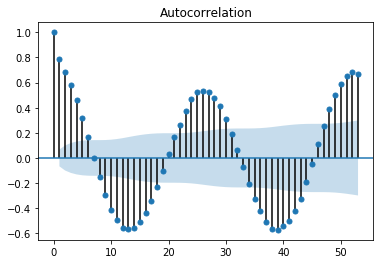

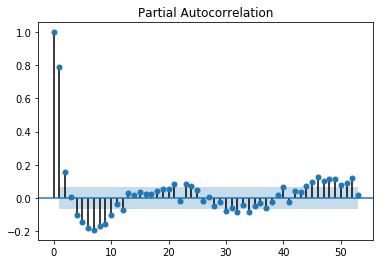

In [14]:
sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values, lags=53)
plt.show()
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values, lags=53)
plt.show()

ACF - для недельного ресемплинга - сезонность 52 недели(2-й по уровню максимум корреляции), по PACF - видна связь с 1-й по 12-ю недели (и повтор с 45 по 52-ю недели) 
Значения истории будем брать до 53-й недели 

In [15]:
p = 53
for i in range(p):
    data_w['t'+str(p-i)]=0
    data_w['t'+str(p-i)].values[p:] = data_w['PJME_MW'].values[i:-(p)+i]

In [16]:
first_diff =np.array(data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values).astype('float32') 
data_w['diff1'] = 0
data_w['diff1'] =  data_w['diff1'].astype('float') 
data_w['diff1'].values[1:] = first_diff

k = 13
for i in range(k):
    data_w['d'+str(k-i)]=0
    data_w['d'+str(k-i)].values[k:] = data_w['diff1'].values[i:-(k)+i]

Добавим сглаживание для поиска основных моделей изменения ряда

In [17]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [18]:
data_w['exp_0_01'] = exponential_smoothing(data_w['PJME_MW'], 0.01)
data_w['exp_0_03'] = exponential_smoothing(data_w['PJME_MW'], 0.03)
data_w['exp_0_04'] = exponential_smoothing(data_w['PJME_MW'], 0.04)
data_w['exp_0_06'] = exponential_smoothing(data_w['PJME_MW'], 0.06)
data_w['exp_0_07'] = exponential_smoothing(data_w['PJME_MW'], 0.07)
data_w['exp_0_08'] = exponential_smoothing(data_w['PJME_MW'], 0.08)

### Горизонт прогнозирования h = 1

Запишем итоговую систему признаков и проведем ее анализ. 

Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1)


In [19]:
from sklearn.preprocessing import StandardScaler

# Целевой признак
scl_target=StandardScaler() 

# p = 53
h = 1

target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(812, 1)

In [20]:
# Входные признаки

scl_x=StandardScaler() 

X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(812, 80)

Отбор признаков

In [21]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)

sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape


(812, 5)

In [22]:
column_names = data_w.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 't52', 't51', 't50', 't1'], dtype='object')

In [23]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(812, 8)

In [24]:
column_namesp = data_w.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 't53', 't52', 't51', 't50', 't49', 't38', 't1'], dtype='object')

In [25]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=500).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(812, 5)

In [26]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0  8  9 10 59]
Номера признаков лучших признаков по процентной форме:  [ 0  7  8  9 10 11 22 59]
Номера признаков для выбора по модели :  [ 0  8  9 11 24]


Выбираем признаки по всем методам сразу

In [27]:
list_param = [ 0 , 7,  8,  9, 10, 11, 22, 24, 59]
X_new = X[:,list_param]
data_w.columns[list_param]

Index(['PJME_MW', 't53', 't52', 't51', 't50', 't49', 't38', 't36', 't1'], dtype='object')

Важны признаки истории, а остальное не играет роли

### Строим модель для предсказания


In [28]:
# сделаем функцию
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

C:\Users\111\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


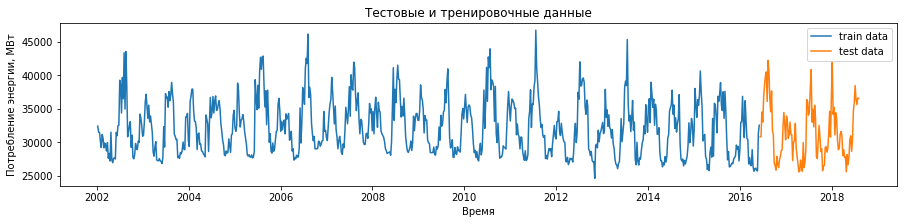

In [29]:
train, test = split_data( data_w, '06-06-2016')

plt.figure( figsize=( 15, 3 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [30]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

Параметры модели подбираем по RandomizedSearchCV (max_depth=3,n_estimators=100)

In [32]:
model_g = GradientBoostingRegressor(max_depth=3, random_state=40, n_estimators=100)
model_l = LinearRegression()

In [33]:
model_g.fit( X_train, y_train )
model_l.fit( X_train, y_train )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [34]:
y_test_pred_g = model_g.predict(X_test)
y_test_pred_l = model_l.predict(X_test)

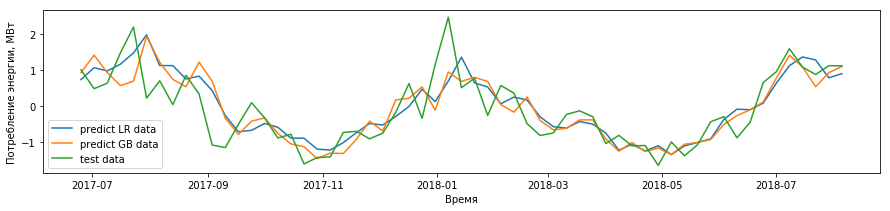

In [35]:
plt.figure( figsize=( 15, 3 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_l, label='predict LR data' )
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

In [36]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [37]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')
er_l = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_l))
print('ошибка LR MAPE :  ', er_l,'%')

ошибка градиентного бустинга MAPE :   5.742823091957391 %
ошибка LR MAPE :   5.8201188278939515 %


Модель GB чуть лучше линейной.

Строим рекурсивную модель

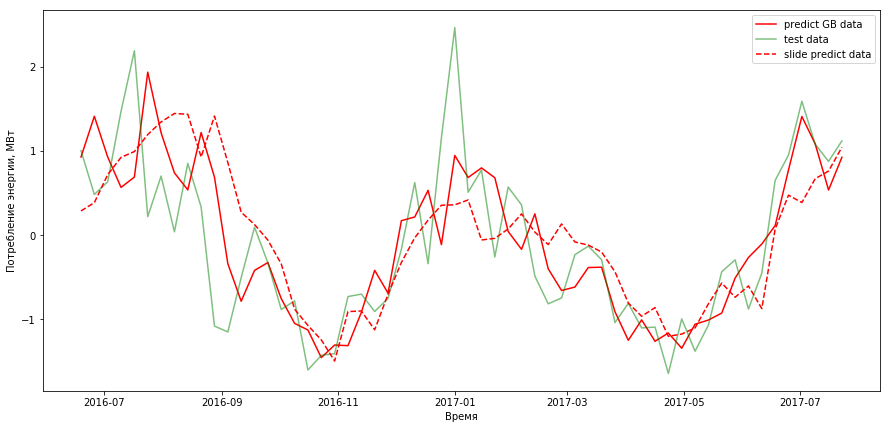

In [38]:
#['PJME_MW', 't53', 't52', 't51', 't50', 't49', 't38', 't36', 't1']
# [ 0 , 7,  8,  9, 10, 11, 22, 24, 59]
X_test_100 = X_test.copy()
X_test_100 = np.vstack([X_train[-p-h:,:],X_test_100])
y_test_100 = y_test_pred_g.copy()
y_test_100 = np.hstack([y_train[-p-h:],y_test_100])
N10 = 58
for ip in range(N10):
    i=ip+p 
    # делаю отступ р для использования данных на первом шаге рекурсии
    y_test_100[i] = model_g.predict(X_test_100[i,:].reshape((1,9)))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    X_test_100[i+1,1] = X_test_100[i-53+1,0]
    X_test_100[i+1,2] = X_test_100[i-52+1,0]
    X_test_100[i+1,3] = X_test_100[i-51+1,0]
    X_test_100[i+1,4] = X_test_100[i-50+1,0]
    X_test_100[i+1,5] = X_test_100[i-49+1,0]
    X_test_100[i+1,6] = X_test_100[i-38+1,0]
    X_test_100[i+1,7] = X_test_100[i-56+1,0]
    X_test_100[i+1,8] = X_test_100[i-1+1,0]

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N10+1],y_test_100[p:N10+p], '--r',label='slide predict data')

plt.legend()
plt.show()            

Оценим ошибку

In [39]:
er_100 = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_100[p+1:]))
print('ошибка LR MAPE :  ', er_100,'%')

ошибка LR MAPE :   5.980694118243265 %


по отдельным участкам

In [40]:
for j in [0,10,20,30,40]:
    er_100j = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[j:j+10]),y_pred = scl_target.inverse_transform( y_test_100[p+1+j:j+10+p+1]))

    print('ошибка рекурсивной модели на отрезке',j,':',j+10,'  MAPE :  ', er_100j,'%')

ошибка рекурсивной модели на отрезке 0 : 10   MAPE :   8.073408053122126 %
ошибка рекурсивной модели на отрезке 10 : 20   MAPE :   7.702621874607837 %
ошибка рекурсивной модели на отрезке 20 : 30   MAPE :   6.742547933737911 %
ошибка рекурсивной модели на отрезке 30 : 40   MAPE :   5.235201554881589 %
ошибка рекурсивной модели на отрезке 40 : 50   MAPE :   4.287744366788867 %


Модель плохо отработала на первом участке текстов (но и базовая модель там делает ошибку). На следующих участках работает чуть хуже чем базовая модель.
Рекурсивные модели работают только в рядах с хорошим повторением предшествующих действий.

### Горизонт h=4

In [41]:
h = 4

# целевой признак
scl_target=StandardScaler() 
target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

# Входные признаки

scl_x=StandardScaler() 
X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

sfp=SelectPercentile(f_regression, percentile=12)
X_new2 = sfp.fit_transform(X, y.ravel())

list_param =np.where(sfp.get_support())[0]
list_param 


array([10, 11, 12, 13, 14, 24, 25, 26, 51, 52], dtype=int64)

Признаки другие . при h=1 использовали совсем другую историю

In [42]:
X_new = X[:,list_param]
data_w.columns[list_param]

Index(['t50', 't49', 't48', 't47', 't46', 't36', 't35', 't34', 't9', 't8'], dtype='object')

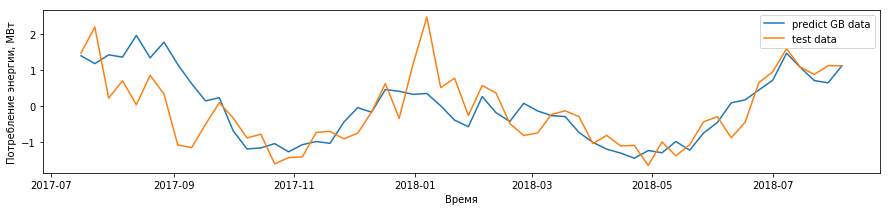

ошибка градиентного бустинга MAPE :   6.762805785887693 %


In [43]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

model_g = GradientBoostingRegressor(max_depth=3, random_state=40, n_estimators=100)
model_g.fit( X_train, y_train )

y_test_pred_g = model_g.predict(X_test)

plt.figure( figsize=( 15, 3 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')

plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

Оценим результаты:

    Модель h=1 - лучший результат 5.7%
    
    Рекурсивная модель - 6%
    
    Модель h=4 - лучший результат 6.8 %
    
Все модели сделали ошибку на участке 2017-07:2017-10     
    

## домашнее задание 5


### Загрузка данных

#### цена нефти:

In [44]:
brent_data = pd.read_csv('my_BRENT2019.csv', index_col=[0])
brent_data.sort_index(inplace=True)
brent_data.index = pd.to_datetime(brent_data.index)
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [45]:
brent_data.index

DatetimeIndex(['2010-09-01', '2010-09-02', '2010-09-03', '2010-09-04',
               '2010-09-05', '2010-09-06', '2010-09-07', '2010-09-08',
               '2010-09-09', '2010-09-10',
               ...
               '2019-08-21', '2019-08-22', '2019-08-23', '2019-08-25',
               '2019-08-26', '2019-08-27', '2019-08-28', '2019-08-29',
               '2019-08-30', '2019-09-01'],
              dtype='datetime64[ns]', name='Дата', length=2667, freq=None)

### кросс-курс валют (рубль-доллар, рубль-евро)

In [46]:
rub_doll = pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx', index_col=[1])
rub_doll.drop(columns=['nominal', 'cdx'], inplace=True)
rub_doll.rename(columns={'curs':'curs dollar'},inplace=True)
rub_doll.index = pd.to_datetime(rub_doll.index)
rub_doll.head()

,curs dollar
data,
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [47]:
rub_euro = pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx', index_col=[1])
rub_euro.drop(columns=['nominal', 'cdx'], inplace=True)
rub_euro.rename(columns={'curs':'curs euro'},inplace=True)
rub_euro.index = pd.to_datetime(rub_euro.index)
rub_euro.head()

,curs euro
data,
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


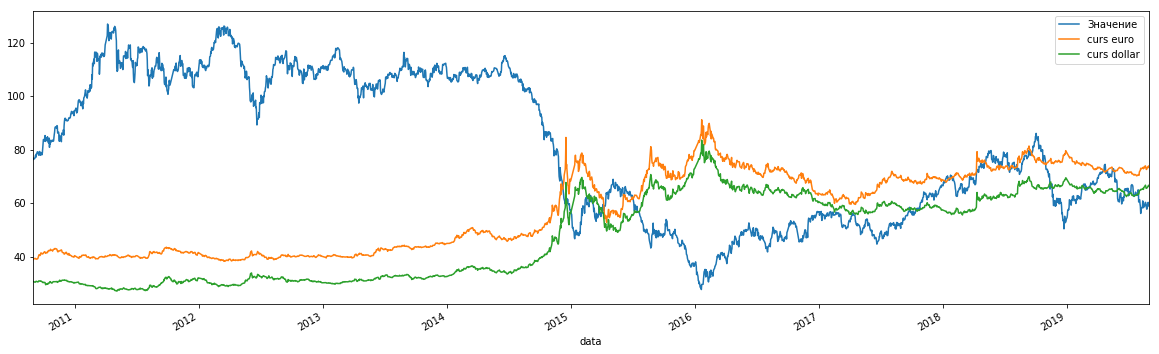

In [48]:
plt.figure(figsize=(20, 6))
brent_data['Значение'].plot()
rub_euro['curs euro'].plot()
rub_doll['curs dollar'].plot()
plt.legend()
plt.show()

Объединим данные по дате

In [49]:
brent_data = pd.concat([brent_data, rub_doll, rub_euro], axis=1)

In [50]:
np.sum(brent_data.isna())

Значение           470
year               470
month              470
dayofmonth         470
quarter            470
dayofyear          470
weekofyear         470
dayofweek          470
is_holiday         470
is_prev_holiday    470
is_next_holiday    470
curs dollar        909
curs euro          909
dtype: int64

Есть пропуски (дни без торговли). Посмотрим на них

In [51]:
ind_brent = np.where(brent_data['Значение'].isna() == True)[0]
brent_data.iloc[ind_brent[:5],:]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,curs dollar,curs euro
2010-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0826,40.8115
2010-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.9480,41.2599
2010-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5094,41.6606
2010-10-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9086,41.6717
2010-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.1243,42.3939


Не торгуем раз в неделю (воскресенье)

In [52]:
ind_doll = np.where(brent_data['curs dollar'].isna() == True)[0]
brent_data.iloc[ind_doll[:5],:]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,curs dollar,curs euro
2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35.0,6.0,0.0,1.0,0.0,NaN,NaN
2010-09-06,76.87,2010.0,9.0,6.0,3.0,249.0,36.0,0.0,1.0,0.0,0.0,NaN,NaN
2010-09-13,79.19,2010.0,9.0,13.0,3.0,256.0,37.0,0.0,0.0,0.0,0.0,NaN,NaN
2010-09-19,78.23,2010.0,9.0,19.0,3.0,262.0,37.0,6.0,0.0,0.0,0.0,NaN,NaN
2010-09-20,79.36,2010.0,9.0,20.0,3.0,263.0,38.0,0.0,0.0,0.0,0.0,NaN,NaN


In [53]:
ind_euro = np.where(brent_data['curs euro'].isna() == True)[0]
brent_data.iloc[ind_euro[:5],:]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,curs dollar,curs euro
2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35.0,6.0,0.0,1.0,0.0,NaN,NaN
2010-09-06,76.87,2010.0,9.0,6.0,3.0,249.0,36.0,0.0,1.0,0.0,0.0,NaN,NaN
2010-09-13,79.19,2010.0,9.0,13.0,3.0,256.0,37.0,0.0,0.0,0.0,0.0,NaN,NaN
2010-09-19,78.23,2010.0,9.0,19.0,3.0,262.0,37.0,6.0,0.0,0.0,0.0,NaN,NaN
2010-09-20,79.36,2010.0,9.0,20.0,3.0,263.0,38.0,0.0,0.0,0.0,0.0,NaN,NaN


с пропусками для валют - похоже на отсутствие торговли воскресенье-понедельник (пока не закончен день - нет ккросс-курса)

### Будем заполнять последним известным значением все пропуски

In [54]:
brent_data['curs dollar'].fillna(method='ffill', inplace=True)
brent_data['curs euro'].fillna(method='ffill', inplace=True)
brent_data['Значение'].fillna(method='ffill', inplace=True)

Поля календаря слабо влияют на значения этого ряда - исключаем их

In [55]:
brent_data = brent_data[['Значение','curs dollar','curs euro']]
#brent_data.index = pd.to_datetime(brent_data.index).date
brent_data.head()

,Значение,curs dollar,curs euro
2010-09-01,76.37,30.8669,39.0127
2010-09-02,76.89,30.8001,39.1654
2010-09-03,76.57,30.6858,39.2901
2010-09-04,76.62,30.6922,39.3505
2010-09-05,76.63,30.6922,39.3505


Сделаем ресемплинг на неделю

In [56]:
brent_data_w= brent_data.resample('W').mean()
brent_data_w.head()

,Значение,curs dollar,curs euro
2010-09-05,76.616000,30.747440,39.233840
2010-09-12,77.673333,30.777050,39.302883
2010-09-19,78.590000,30.887129,39.984557
2010-09-26,78.558571,31.003800,41.040657
2010-10-03,81.582857,30.585086,41.382686


In [57]:
brent_data_w.dropna(inplace=True)
brent_data_w.head()

,Значение,curs dollar,curs euro
2010-09-05,76.616000,30.747440,39.233840
2010-09-12,77.673333,30.777050,39.302883
2010-09-19,78.590000,30.887129,39.984557
2010-09-26,78.558571,31.003800,41.040657
2010-10-03,81.582857,30.585086,41.382686


In [58]:
adfuller(brent_data_w['Значение'], regression='ctt')

(-2.789814682013301,
 0.4038984647442564,
 5,
 464,
 {'1%': -4.396274283817996,
  '5%': -3.8451769989336255,
  '10%': -3.561172289966388},
 1974.0745861660207)

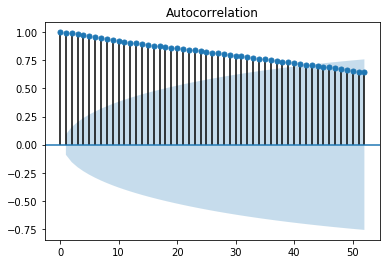

C:\Users\111\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


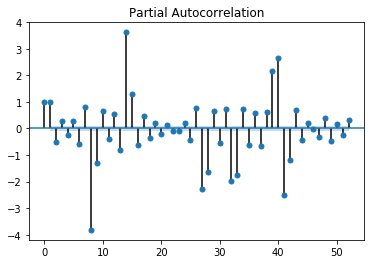

In [59]:
plot_acf(brent_data_w['Значение'], lags=52)
plt.show()

plot_pacf(brent_data_w['Значение'], lags=52)
plt.show()

Ряд нестационарный зависит от длинной истории (45 недель назад влияют на прогноз)

делаем 1-е разности (продифференцируем ряд)

In [60]:
brent_data_w['d_brent'] = brent_data_w['Значение'].diff(1)
brent_data_w['doll_brent'] = brent_data_w['curs dollar'].diff(1)
brent_data_w['euro_brent'] = brent_data_w['curs euro'].diff(1)
brent_data_w.dropna(inplace=True)  

Проверим разности на стационарность

In [61]:
adfuller(brent_data_w['d_brent'], regression='ctt')

(-13.687495282869419,
 2.532471418393266e-22,
 1,
 467,
 {'1%': -4.396111652921828,
  '5%': -3.84509447012365,
  '10%': -3.5611212965378463},
 1975.1079117943239)

P-value = 0 - ряд стационарен - Таким образом, порядок интегрирования 1

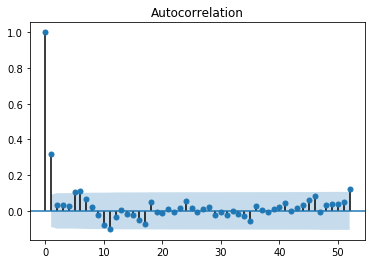

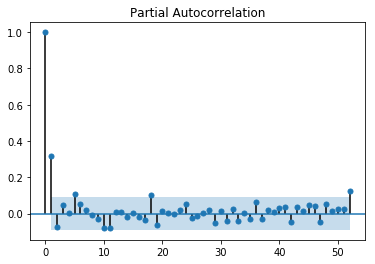

In [62]:
plot_acf(brent_data_w['d_brent'], lags=52)
plt.show()

plot_pacf(brent_data_w['d_brent'], lags=52)
plt.show()

Влияет только первое значение по глубине истории для разностей

### ARIMA

параметры

In [63]:
S = 0
d, D = 1, 0
p, P = 6, 0
q, Q = 6, 0

ps, Ps = np.arange(0, p + 1), np.arange(0, P + 1)
qs, Qs = np.arange(0, q + 1), np.arange(0, Q + 1)

In [64]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

49

#### Перебор параметров:

In [65]:
%%time
results = []
opt_aic = float('inf')
warnings.filterwarnings('ignore')

for n, param in enumerate(parameters_list):
    try:
        model=SARIMAX(brent_data_w['Значение'].values[330:427], order=(param[0], d, param[1]), 
                      seasonal_order=(param[2], D, param[3], S), 
                                enforce_stationarity= False ,
                                enforce_invertibility=False).fit(disp=-1)
    except:
        continue
    aic = model.aic
    if aic < opt_aic:
        opt_model = model
        opt_aic = aic
        opt_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 12.3 s


Топ-5 моделей

In [66]:
result_table = pd.DataFrame(results, columns=['parameters', 'aic'])
result_table.sort_values(by='aic', ascending=True).head()

NameError: name 'results' is not defined

#### Лучшая модель:

In [ ]:
print(opt_model.summary())

#### Анализ остатков:

In [ ]:
opt_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Распределение остатков близко к нормальному. Остатки стационарны.


## Выводы по ARIMA

Таким образом, рабочая модель : 
   - q = 6 -  сглаживание
   - d = 1 - учитываем 1-е разности 
   - p = 0 - все значения для текущего момента 

   - сезона нет.


In [ ]:
final_model=SARIMAX(brent_data_w['Значение'].values[350:427], order=(0, 1, 6), 
                      seasonal_order=(0,0, 0, 0) ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False ).fit(disp=-1)
pred_dynamic = final_model.forecast(10)    #делаем предсказание на 10 точки от текущего
 
plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения 
plt.plot(brent_data_w['Значение'].values[427:437],'or',label='true')
plt.title('следующих 10 точек ряда')
plt.legend()
plt.plot()
plt.show()

In [67]:
q=6
p=1 # добавляю историю, только для генерации наиболее общего способа построения признаков для примеров

h = 1 # горизонт прогноза



### Создание признаков

Берем сглаживание 
Текущее значение
текущее значение 1-й разности

In [68]:
brent_data_w['ma1']=brent_data_w['Значение'].rolling(q).mean()
brent_data_w = brent_data_w.iloc[1:,:]
brent_data_w.head()

,Значение,curs dollar,curs euro,d_brent,doll_brent,euro_brent,ma1
2010-09-19,78.590000,30.887129,39.984557,0.916667,0.110079,0.681674,NaN
2010-09-26,78.558571,31.003800,41.040657,-0.031429,0.116671,1.056100,NaN
2010-10-03,81.582857,30.585086,41.382686,3.024286,-0.418714,0.342029,NaN
2010-10-10,84.152857,30.112129,41.636057,2.570000,-0.472957,0.253371,NaN
2010-10-17,83.392857,30.017657,41.987514,-0.760000,-0.094471,0.351457,80.658413


In [69]:
for i in range(p):
    brent_data_w[f'p{i+1}'] = 0
    brent_data_w[f'p{i+1}'].values[p:]=brent_data_w['Значение'].values[p-i-1:-i-1]
    

brent_data_w.head()

,Значение,curs dollar,curs euro,d_brent,doll_brent,euro_brent,ma1,p1
2010-09-19,78.590000,30.887129,39.984557,0.916667,0.110079,0.681674,NaN,0
2010-09-26,78.558571,31.003800,41.040657,-0.031429,0.116671,1.056100,NaN,78
2010-10-03,81.582857,30.585086,41.382686,3.024286,-0.418714,0.342029,NaN,78
2010-10-10,84.152857,30.112129,41.636057,2.570000,-0.472957,0.253371,NaN,81
2010-10-17,83.392857,30.017657,41.987514,-0.760000,-0.094471,0.351457,80.658413,84


Будем  смотреть только на текущие значения (без глубины истории), 1-е разности и сглаживание по MA

Построим целевой признак и признаки для обучения:

In [70]:
brent_data_w.dropna(inplace=True)  
df = brent_data_w.iloc[p:-h,:].copy()  # входы модели 
df['target'] = 0
df['target']=brent_data_w.iloc[p+h:,0].values.copy()   # выход модели
brent_data_w.dropna(inplace=True)    
df.head()

,Значение,curs dollar,curs euro,d_brent,doll_brent,euro_brent,ma1,p1,target
2010-10-24,82.810000,30.512871,42.491329,-0.582857,0.495214,0.503814,81.514524,83,83.330000
2010-10-31,83.330000,30.562071,42.509329,0.520000,0.049200,0.018000,82.304524,82,87.003333
2010-11-07,87.003333,30.777117,43.020217,3.673333,0.215045,0.510888,83.711984,83,87.552857
2010-11-14,87.552857,30.750257,42.485571,0.549524,-0.026860,-0.534645,84.706984,87,84.677143
2010-11-21,84.677143,31.029600,42.289557,-2.875714,0.279343,-0.196014,84.794365,87,85.177143


### Разделение данных на train и test

In [71]:
def split_data_b(df, split_date):
    return df.loc[df.index.get_level_values(df.index.name) <= split_date].copy(), \
           df.loc[df.index.get_level_values(df.index.name) >  split_date].copy()

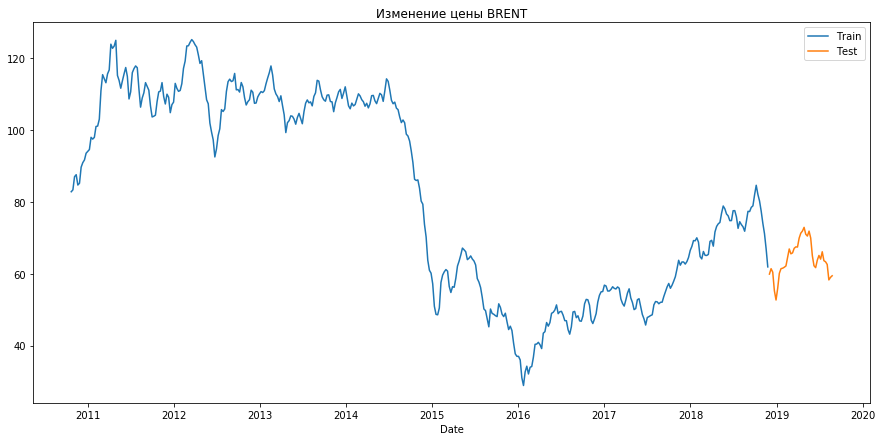

In [72]:
train, test = split_data_b(df, '2018-12-01')

plt.figure( figsize=(15, 7))
plt.plot(train.index,train.iloc[:,0], label='Train' )
plt.plot(test.index,test.iloc[:,0], label='Test')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.legend(loc='best')
plt.show()

In [73]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]
X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

In [74]:
X_train.shape

(423, 8)

### Обучение модели

In [91]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

In [92]:
model_g = GradientBoostingRegressor(max_depth=4, random_state=0, n_estimators=1250)

In [93]:
scx= StandardScaler().fit(X_train)
X_train_s = scx.transform(X_train)
X_test_s = scx.transform(X_test)

scy= StandardScaler().fit(y_train.values.reshape(y_train.shape[0], 1))
y_train_s = scy.transform(y_train.values.reshape(y_train.shape[0], 1))
y_test_s = scy.transform(y_test.values.reshape(y_test.shape[0], 1))

C:\Users\111\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\111\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\111\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
model_g.fit(X_train_s, y_train_s)

C:\Users\111\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1250, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

### Прямое прогнозирование

#### Наиболее важные признаки:

In [95]:
feature_importances = pd.Series(model_g.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False)

Значение       0.529198
curs euro      0.327546
curs dollar    0.136195
ma1            0.003730
d_brent        0.001572
euro_brent     0.000685
doll_brent     0.000673
p1             0.000401
dtype: float64

Самая сильная связь -текущее значение цены нефти и курс доллара :)

Следующий по силе признак - сглаживание цены

Исторические значения цены и разности значительно слабее при решении задачи предсказания как по курсам, так и по самой цене нефти 


## Прогноз

In [96]:
y_test_pred_s = model_g.predict(X_test_s)

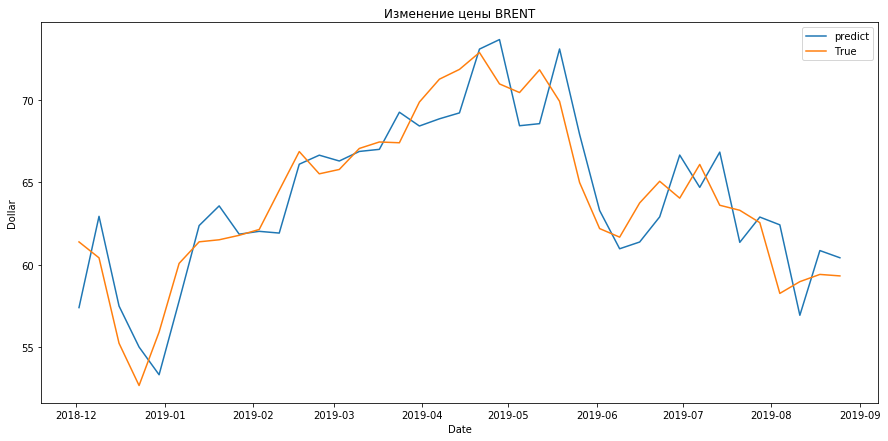

In [97]:
plt.figure( figsize=(15, 7))
plt.plot(test.index,scy.inverse_transform(y_test_pred_s), label='predict' )
plt.plot(test.index,scy.inverse_transform(y_test_s), label='True')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.ylabel('Dollar')
plt.legend()
plt.show()

Ошибка

In [98]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [99]:
er_g = mean_absolute_percentage_error(y_true=scy.inverse_transform( y_test_s),y_pred = scy.inverse_transform( y_test_pred_s))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   8.64000555810406 %


Исключим курсы валют из прогноза, т.к. они коррелированы с текущим значением цены.

In [100]:
list_feat =(np.array(range(p+2))+6)

df_rec=df.iloc[:,[0,3]+list_feat.tolist()].copy()
df_rec.head()

,Значение,d_brent,ma1,p1,target
2010-10-24,82.810000,-0.582857,81.514524,83,83.330000
2010-10-31,83.330000,0.520000,82.304524,82,87.003333
2010-11-07,87.003333,3.673333,83.711984,83,87.552857
2010-11-14,87.552857,0.549524,84.706984,87,84.677143
2010-11-21,84.677143,-2.875714,84.794365,87,85.177143


C:\Users\111\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\111\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\111\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':
C:\Users\111\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


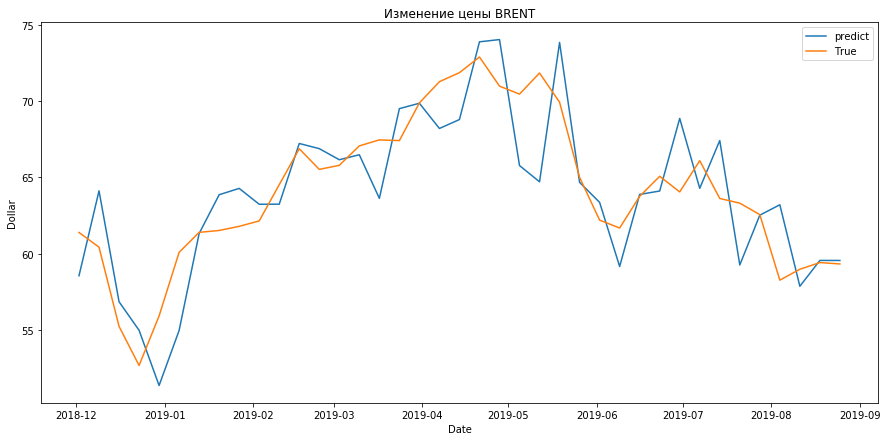

ошибка градиентного бустинга MAPE :   8.835880322446263 %


In [101]:
train_c, test_c = split_data_b(df_rec, '2018-12-01')

X_train_c = train_c.iloc[:, :-1]
y_train_c = train_c.iloc[:, -1]
X_test_c = test_c.iloc[:, :-1]
y_test_c = test_c.iloc[:, -1]

model_gc = GradientBoostingRegressor(max_depth=10, random_state=0, n_estimators=1550)

scxc= StandardScaler().fit(X_train_c)
X_train_cs = scxc.transform(X_train_c)
X_test_cs = scxc.transform(X_test_c)

scyc= StandardScaler().fit(y_train_c.values.reshape(y_train_c.shape[0], 1))
y_train_cs = scyc.transform(y_train_c.values.reshape(y_train_c.shape[0], 1))
y_test_cs = scyc.transform(y_test_c.values.reshape(y_test_c.shape[0], 1))

model_gc.fit(X_train_cs, y_train_cs)


y_test_pred_cs = model_gc.predict(X_test_cs)


plt.figure( figsize=(15, 7))
plt.plot(test_c.index,scyc.inverse_transform(y_test_pred_cs), label='predict' )
plt.plot(test_c.index,scyc.inverse_transform(y_test_cs), label='True')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.ylabel('Dollar')
plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=scyc.inverse_transform( y_test_cs),y_pred = scyc.inverse_transform( y_test_pred_cs))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')


Ошибка модели несколько больше, но нет внешних факторов (курсов валют). Можем построить рекурсивную модель 

### Рекурсивное прогнозирование


In [102]:
x_shape = X_train_c.shape[0]

In [103]:
df_rec.head() 

,Значение,d_brent,ma1,p1,target
2010-10-24,82.810000,-0.582857,81.514524,83,83.330000
2010-10-31,83.330000,0.520000,82.304524,82,87.003333
2010-11-07,87.003333,3.673333,83.711984,83,87.552857
2010-11-14,87.552857,0.549524,84.706984,87,84.677143
2010-11-21,84.677143,-2.875714,84.794365,87,85.177143


In [104]:
print(X_test_c.iloc[0,:])

Значение    59.882857
d_brent     -2.002857
ma1         68.550000
p1          61.000000
Name: 2018-12-02 00:00:00, dtype: float64


#### Начало исходной тестовой части данных для рекурсивной модели:

In [105]:
ind_test=np.where(df_rec.index.get_level_values(df_rec.index.name) == '2019-01-06')[0][0]
df_rec_test = df_rec.iloc[ind_test-q+1:,:].copy()
df_rec_test.head(5+q)

,Значение,d_brent,ma1,p1,target
2018-12-02,59.882857,-2.002857,68.550000,61,61.390000
2018-12-09,61.390000,1.507143,65.877381,59,60.422857
2018-12-16,60.422857,-0.967143,63.606905,61,55.232857
2018-12-23,55.232857,-5.190000,60.953095,60,52.668571
2018-12-30,52.668571,-2.564286,58.580476,55,55.916000
2019-01-06,55.916000,3.247429,57.585524,52,60.085714
2019-01-13,60.085714,4.169714,57.619333,55,61.395714
2019-01-20,61.395714,1.310000,57.620286,60,61.520000
2019-01-27,61.520000,0.124286,57.803143,61,61.791429
2019-02-03,61.791429,0.271429,58.896238,61,62.145714


In [107]:
df_rec_test.shape

(39, 5)

#### Рекурсии (обновление ):

In [108]:
h_step = 20  # число шагов модели в рекурсивной форме

for i in range(h_step):
    f_w = scxc.transform(df_rec_test.iloc[i+q, :-1].values.reshape(1, 4))
    df_rec_test.iloc[i+q+1, 0] = scyc.inverse_transform(model_gc.predict(f_w))[0]
    df_rec_test.iloc[i+q+1, 1] = df_rec_test.iloc[i+q+1, 0] - df_rec_test.iloc[i+q, 0] 
    df_rec_test.iloc[i+q+1, 2] = np.mean(df_rec_test.iloc[i+1:i+q+1, 0] )
    df_rec_test.iloc[i+q+1, 2] = df_rec_test.iloc[i+q, 0] 


In [109]:

df_rec_test.head(5+q)

,Значение,d_brent,ma1,p1,target
2018-12-02,59.882857,-2.002857,68.550000,61,61.390000
2018-12-09,61.390000,1.507143,65.877381,59,60.422857
2018-12-16,60.422857,-0.967143,63.606905,61,55.232857
2018-12-23,55.232857,-5.190000,60.953095,60,52.668571
2018-12-30,52.668571,-2.564286,58.580476,55,55.916000
2019-01-06,55.916000,3.247429,57.585524,52,60.085714
2019-01-13,60.085714,4.169714,57.619333,55,61.395714
2019-01-20,61.319258,1.233544,60.085714,60,61.520000
2019-01-27,63.247790,1.928531,61.319258,61,61.791429
2019-02-03,63.251929,0.004139,63.247790,61,62.145714


In [110]:
scyc.inverse_transform(y_test_pred_cs[:20])

array([58.55108237, 64.11896273, 56.84755802, 54.97678729, 51.35438097,
       54.96405501, 61.31925849, 63.86396011, 64.27898282, 63.23831398,
       63.24417797, 67.22329596, 66.88614051, 66.15829214, 66.48398317,
       63.62667106, 69.50925309, 69.8613717 , 68.20831176, 68.79386209])

#### h_step тестовых отсчетов:

- прямое прогнозирование (GB);
- рекурсивное прогнозирование (GB with recursion).

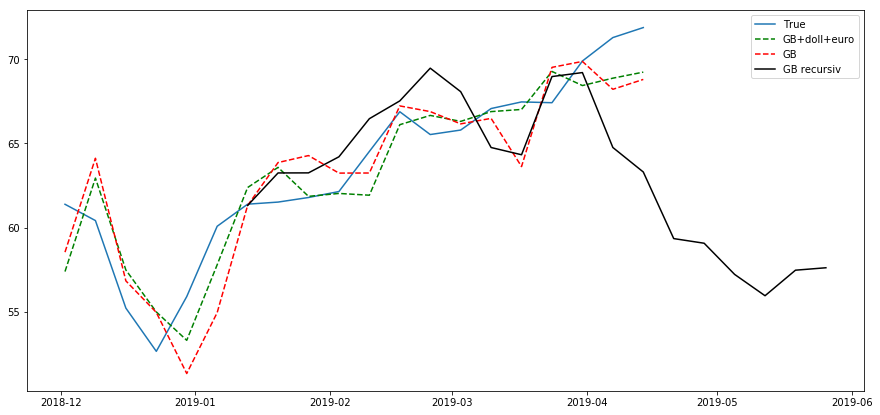

In [111]:
plt.figure(figsize=(15, 7))

plt.plot(y_test.index[:h_step],y_test.values[:h_step], label='True')
plt.plot(y_test.index[:h_step],scy.inverse_transform(y_test_pred_s[:h_step]),'--g',label='GB+doll+euro')
plt.plot(y_test.index[:h_step],scyc.inverse_transform(y_test_pred_cs[:h_step]), '--r',label='GB')
plt.plot(df_rec_test.index[q:h_step+q],df_rec_test.iloc[1+q:h_step+q+1, 0].values, 'k',label='GB recursiv')


plt.legend()
plt.show()

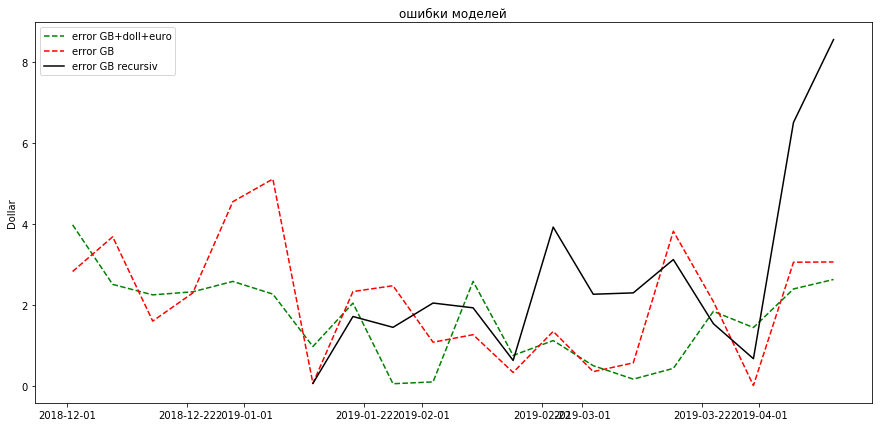

In [112]:
plt.figure(figsize=(15, 7))

plt.plot(y_test.index[:h_step],np.abs(scy.inverse_transform(y_test_pred_s[:h_step])-y_test.values[:h_step]),'--g',label='error GB+doll+euro')
plt.plot(y_test.index[:h_step],np.abs(scyc.inverse_transform(y_test_pred_cs[:h_step])-y_test.values[:h_step]), '--r',label='error GB')
plt.plot(df_rec_test.index[q:h_step],np.abs(df_rec_test.iloc[1+q:h_step+1, 0].values - y_test.values[q:h_step]), 'k',label='error GB recursiv')
plt.title('ошибки моделей')
plt.ylabel('Dollar')
plt.legend()
plt.show()

**Вывод:**  

Курс валюты связан с ценой нефти, но скорее зависит от нее.Поэтому ряд с учетом курса и без него работает практически одинаково.

Рекурсивный прогноз слабее, но тенденцию ряда видимт дальше, чем на p - истории (в нашем случае пока есть монотонность). Рекурсивный прогноз хорошо работает в рядах с выраженными временными связями (например "Потребление энергии")

Посмотрим на другой горизонт прогноза h = 10

## Изменим h (h=10)

C:\Users\111\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\111\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()
C:\Users\111\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\111\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


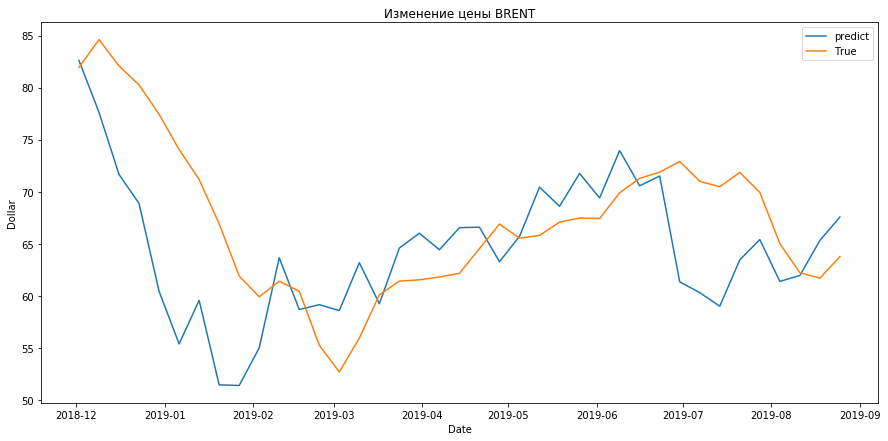

ошибка градиентного бустинга MAPE :   11.699017953372048 %


In [113]:
h_10=10
    
df_rec10 = df_rec.copy()
df_rec10['target'].values[h_10:]=df_rec10['target'].values[:-h_10]

train_c10, test_c10 = split_data_b(df_rec10, '2018-12-01')

X_train_c10 = train_c10.iloc[:, :-1]
y_train_c10 = train_c10.iloc[:, -1]
X_test_c10 = test_c10.iloc[:, :-1]
y_test_c10 = test_c10.iloc[:, -1]

model_gc10 = GradientBoostingRegressor(max_depth=4, random_state=0, n_estimators=1050)

scxc10= StandardScaler().fit(X_train_c10)
X_train_cs10 = scxc10.transform(X_train_c10)
X_test_cs10 = scxc10.transform(X_test_c10)

scyc10= StandardScaler().fit(y_train_c10.values.reshape(y_train_c10.shape[0], 1))
y_train_cs10 = scyc10.transform(y_train_c10.values.reshape(y_train_c10.shape[0], 1))
y_test_cs10 = scyc10.transform(y_test_c10.values.reshape(y_test_c10.shape[0], 1))

model_gc10.fit(X_train_cs10, y_train_cs10)


y_test_pred_cs10 = model_gc10.predict(X_test_cs10)


plt.figure( figsize=(15, 7))
plt.plot(test_c10.index,scyc10.inverse_transform(y_test_pred_cs10), label='predict' )
plt.plot(test_c10.index,scyc10.inverse_transform(y_test_cs10), label='True')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.ylabel('Dollar')
plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=scyc10.inverse_transform( y_test_cs10),y_pred = scyc10.inverse_transform( y_test_pred_cs10))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

## Вывод: 
Изменяем горизонт прогноза

     - при увеличении h -  имеет смысл строить более общую модель (понизить высоту деревьев)
     - ошибка тем больше, чем дальше прогноз по h
     - видно запаздывание модели

## Задание к уроку 5
## Прогнозирование  по первым разностям:)

C:\Users\111\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


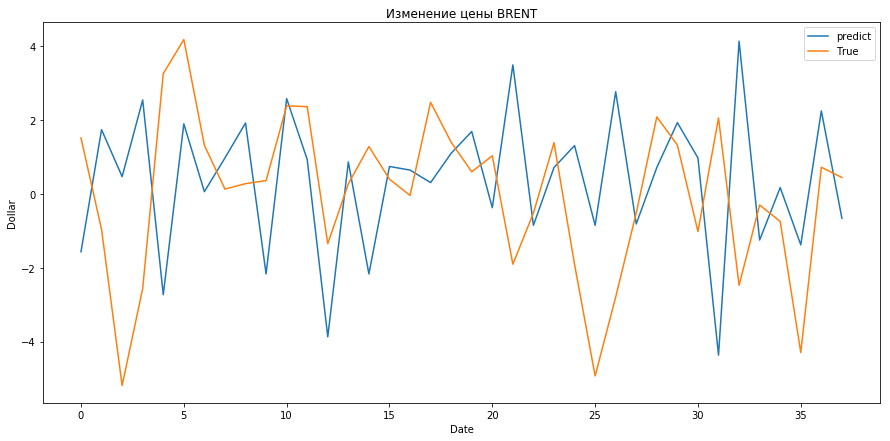

ошибка градиентного бустинга MAE :   26.96623584195719 %


In [114]:
train_d, test_d = split_data_b(df_rec.iloc[:,1], '2018-12-01')
# делаем прогноз только для небольшой части ряда, т.к. помним, что ряд менял свою дисперсию в 2015 и 2016 годах

X_train_d = train_d.iloc[:-h].values
y_train_d = train_d.iloc[h:].values
X_test_d = test_d.iloc[:-h].values
y_test_d = test_d.iloc[h:].values

model_gd = GradientBoostingRegressor(max_depth=10, random_state=0, n_estimators=1550)

scxd= StandardScaler().fit(X_train_d.reshape(y_train_d.shape[0], 1))
X_train_ds = scxd.transform(X_train_d.reshape(y_train_d.shape[0], 1))
X_test_ds = scxd.transform(X_test_d.reshape(y_test_d.shape[0], 1))

scyd= StandardScaler().fit(y_train_d.reshape(y_train_d.shape[0], 1))
y_train_ds = scyd.transform(y_train_d.reshape(y_train_d.shape[0], 1))
y_test_ds = scyd.transform(y_test_d.reshape(y_test_d.shape[0], 1))

model_gd.fit(X_train_ds, y_train_ds)


y_test_pred_ds = model_gd.predict(X_test_ds)


plt.figure( figsize=(15, 7))
plt.plot(scyd.inverse_transform(y_test_pred_ds), label='predict' )
plt.plot(scyd.inverse_transform(y_test_ds), label='True')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.ylabel('Dollar')
plt.legend()
plt.show()

er_g = np.abs(scyc.inverse_transform( y_test_ds)- scyc.inverse_transform( y_test_pred_ds)).mean()

print('ошибка градиентного бустинга MAE :  ', er_g,'%')


## :) Вывод  

Прогнозное значение модели не выходит за границы изменений ряда первых разностей далеко  :

- модель ряда в первых разностях - стационарна!!!!! 
- можно предсказать диапазон случайных положений первых разностей, но не их конкретное значение. 

Такой ряд описывают его статистиками. Это случайные биения.

## Итак:
    
    - Для прогнозирования используем результаты анализа по ARIMA
    - Строим модель как можно более простую
    - Прогнозируем нестационарную часть (т.е. сглаживаем)
    - Стационарную часть описываем статистиками